In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

# Data Preprocessing


In [4]:
import os

In [5]:
INPUT_DIR = os.path.join("..", "artifacts", "raw")

In [6]:
rating_df = pd.read_csv(
    INPUT_DIR + "/animelist.csv",
    low_memory=True,
    usecols=["user_id", "anime_id", "rating"],
)

In [7]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [8]:
len(rating_df)

5000000

In [9]:
n_ratings = rating_df["user_id"].value_counts()

# Filter out users with less than 400 ratings (not enough data for that specific user)
rating_df = rating_df[
    rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)
].copy()

In [10]:
len(rating_df)

3246641

In [11]:
min_rating = min(rating_df["rating"])

In [12]:
max_rating = max(rating_df["rating"])

In [13]:
avg_rating = np.mean(rating_df["rating"])

In [14]:
min_rating, max_rating, avg_rating

(0, 10, 4.122732695114736)

### Normalization

Normalize the rating to be between 0 and 1 (Min-Max Scaler).
Which gives a better distribution of ratings and equal weight to all ratings.


In [15]:
rating_df["rating"] = (
    rating_df["rating"]
    .apply(lambda x: (x - min_rating) / (max_rating - min_rating))
    .values.astype(np.float64)
)

In [16]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

### Encoding

Encode the user_id to a unique integer using the index in this case. The model can understand the encoder ID better

```ts
11054 : 12  -> user2user_encoded
12 : 11054 ---> user2user_decoded
```

Even if user IDs are already numbers like 1, 2, 3, they might not start from 0 or be continuous.
Neural networks, especially embedding layers, expect indices starting from 0 and going up to n-1.
So re-encoding them using enumerate or LabelEncoder ensure the IDs are compact, zero-based, and continuous — which is exactly what embeddings need.


In [17]:
user_ids = rating_df["user_id"].unique().tolist()


user2user_encoded = {x: i for i, x in enumerate(user_ids)}

# Keep the decoding so it can be indexed into other datasets through joins
user2user_decoded = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [18]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [19]:
# Encode anime ids the same way
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [20]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [21]:
# Randomize the data to prevent any order bias / data leakage
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [22]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353


In [23]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"]

In [24]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [25]:
# Works the same as train_test_split
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [26]:
type(X_train)

numpy.ndarray

In [27]:
# Separate the user and anime ids
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [28]:
X_train_array

[array([ 120, 1195, 1591, ...,  368, 2198,   81]),
 array([1377, 1216, 1239, ...,  861, 2402, 1262])]

# Model Architecture

Component Breakdown

1. Embeddings (Core of the Model)

```py
user_embedding = Embedding(input_dim=n_users, output_dim=embedding_size)(user)
anime_embedding = Embedding(input_dim=n_anime, output_dim=embedding_size)(anime)
```

- What they do: Transform user IDs and anime IDs into dense 128-dimensional vectors
- Why: These embeddings learn latent features like:
  - User embeddings: "This user likes action, dislikes romance, prefers newer anime"
  - Anime embeddings: "This anime has lots of action, minimal romance, recent release"
- Each user/anime gets a unique learnable vector that captures their characteristics

2. Dot Product (Similarity Measure)

```py
x = Dot(name="dot_product", normalize=True, axes=2)([user_embedding, anime_embedding])
```

- What it does: Computes how similar a user's preferences are to an anime's characteristics
- normalize=True: Uses cosine similarity (angle between vectors) rather than raw dot product
  - Makes predictions more stable
  - Focuses on direction (preference pattern) rather than magnitude
- Intuition: If user and anime vectors point in similar directions → high compatibility → higher rating

3. Post-Processing Layers

```py
x = Flatten()(x)                           # Reshape to 1D
x = Dense(1, kernel_initializer="he_normal")(x)  # Single output node
x = BatchNormalization()(x)                # Normalize activations
x = Activation("sigmoid")(x)               # Squash to [0, 1]
```

- `Dense(1)`: Combines the similarity score into a final prediction
- `BatchNormalization`: Stabilizes training
- Sigmoid activation`: Outputs a value between 0 and 1 (likely normalized rating)

4. Loss Function

```py
model.compile(loss="binary_crossentropy", metrics=["mae", "mse"], optimizer="Adam")
```

- binary_crossentropy: Treats this as a binary classification-style problem
  - Suggests ratings are normalized to [0, 1] range
  - Optimizes probability of user liking an anime
- Metrics: Mean Absolute Error (MAE) and Mean Squared Error (MSE) track prediction accuracy

---

How It Works

1. Input: User ID (e.g., 42) and Anime ID (e.g., 1337)
2. Lookup: Retrieve their learned 128-D embedding vectors
3. Compare: Calculate cosine similarity between vectors
4. Predict: Transform similarity into a rating prediction (0-1)
5. Train: Adjust embeddings so predictions match actual user ratings

---

Example Analogy

- Think of it like a matchmaking system:
- Each user has a "taste profile" (128 numbers describing their preferences)
- Each anime has a "characteristic profile" (128 numbers describing its features)
- The dot product asks: "How well do these profiles match?"
- The final layers fine-tune this match into a rating


In [29]:
n_users = len(user2user_encoded)
n_anime = len(anime2anime_encoded)

In [30]:
n_users, n_anime

(4203, 17149)

In [ ]:
def RecommenderNet():
    embedding_size = 128

    # User embedding layer
    user = Input(name="user", shape=[1])
    user_embedding = Embedding(
        name="user_embedding", input_dim=n_users, output_dim=embedding_size
    )(user)

    # Anime embedding layer
    anime = Input(name="anime", shape=[1])
    anime_embedding = Embedding(
        name="anime_embedding", input_dim=n_anime, output_dim=embedding_size
    )(anime)

    # Dot product of user and anime embeddings to get the normalized (better) similarity score between them
    x = Dot(name="dot_product", normalize=True, axes=2)(
        [user_embedding, anime_embedding]
    )

    x = Flatten()(x)

    x = Dense(1, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    # The input was separated into user and anime for this purpose
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss="binary_crossentropy", metrics=["mae", "mse"], optimizer="Adam")
    return model

In [32]:
model = RecommenderNet()

2025-11-10 08:24:20.456660: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-11-10 08:24:20.458991: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-11-10 08:24:20.459124: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2025-11-10 08:24:20.459171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-10 08:24:20.459186: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [33]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

# Model Training


In [34]:
# Learning Rate Callback fn from StackOverflow
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8


def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr - start_lr) / ramup_epochs * epoch + start_lr

    if epoch < ramup_epochs + sustain_epochs:
        return max_lr

    return (max_lr - min_lr) * exp_decay ** (
        epoch - ramup_epochs - sustain_epochs
    ) + min_lr

In [35]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)
checkpoint_filepath = "./weights.weights.h5"

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
)

early_stopping = EarlyStopping(
    patience=3, monitor="val_loss", mode="min", restore_best_weights=True
)

callbacks = [model_checkpoint, lr_callback, early_stopping]

In [36]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=callbacks,
)

Epoch 1/20


2025-11-10 08:24:27.573321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.8037 - mae: 0.3826 - mse: 0.1982 - val_loss: 0.7611 - val_mae: 0.3751 - val_mse: 0.1846 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.8001 - mae: 0.3813 - mse: 0.1969 - val_loss: 0.7988 - val_mae: 0.3826 - val_mse: 0.1974 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.7942 - mae: 0.3791 - mse: 0.1945 - val_loss: 0.7987 - val_mae: 0.3827 - val_mse: 0.1973 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7856 - mae: 0.3758 - mse: 0.1911 - val_loss: 0.7954 - val_mae: 0.3821 - val_mse: 0.1961 - learning_rate: 3.4000e-05


In [37]:
model.load_weights(checkpoint_filepath)

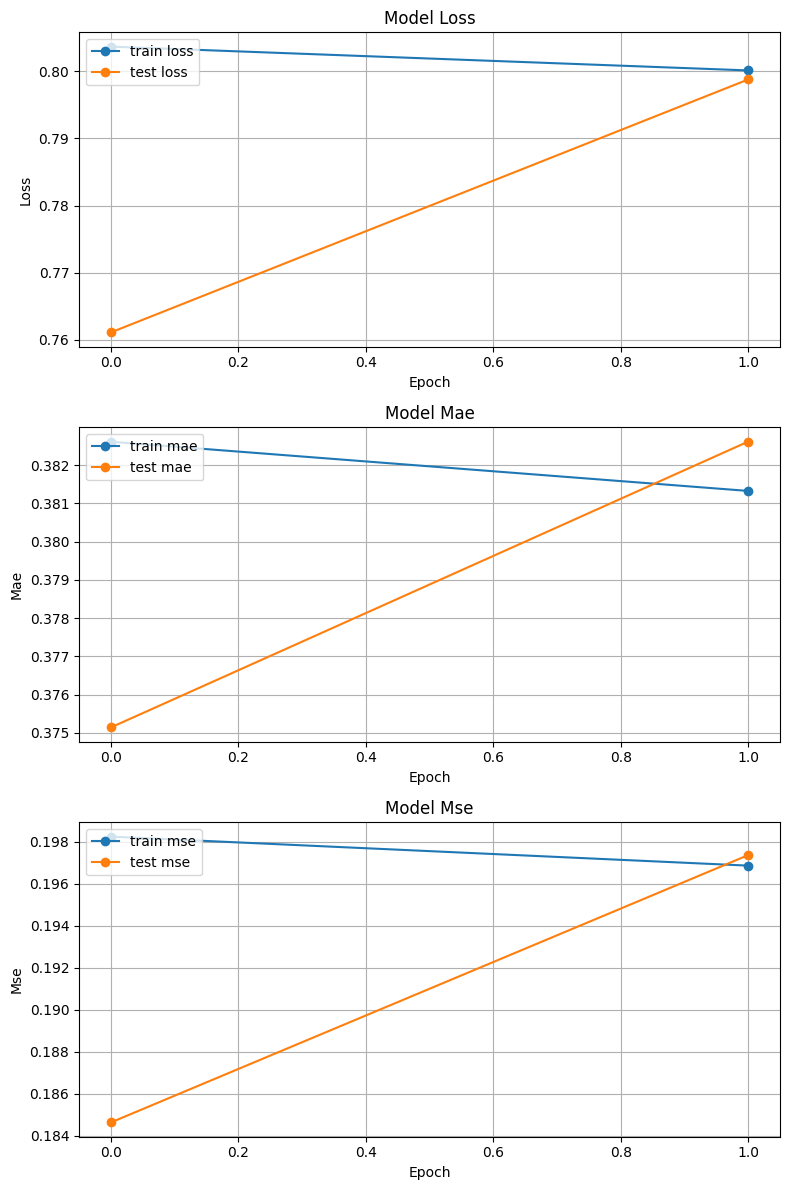

In [38]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [39]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights

In [41]:
# Extract weights for anime and user embeddings to use for recommendations
anime_weights = extract_weights("anime_embedding", model)
user_weights = extract_weights("user_embedding", model)

# Analyze associated files for recommendations


### anime.csv


In [42]:
df = pd.read_csv(INPUT_DIR + "/anime.csv", low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [43]:
df = df.replace("Unknown", np.nan)

In [44]:
def getAnimeNameByID(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [ ]:
# Create aliases for easier access
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x: getAnimeNameByID(x))

In [46]:
getAnimeNameByID(6702)

'Fairy Tail'

In [ ]:
# Sort by score to get the most popular animes
df.sort_values(
    by=["Score"], inplace=True, ascending=False, kind="quicksort", na_position="last"
)

In [48]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [ ]:
# Filter only required columns
df = df[
    [
        "anime_id",
        "eng_version",
        "Score",
        "Genres",
        "Episodes",
        "Type",
        "Premiered",
        "Members",
    ]
]

In [50]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [93]:
# Get the anime frame for a given anime id or name
def getAnimeFrame(anime, df):
    try:
        if isinstance(anime, int):
            return df[df.anime_id == anime]

        if isinstance(anime, str):
            return df[df.eng_version == anime]
    except:
        return None

In [52]:
getAnimeFrame(40028, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [53]:
getAnimeFrame("Steins;Gate", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


### anime_with_synopsis.csv


In [54]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]
synopsis_df = pd.read_csv(INPUT_DIR + "/anime_with_synopsis.csv", usecols=cols)
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [85]:
synopsis_df.columns

Index(['MAL_ID', 'Name', 'Genres', 'sypnopsis'], dtype='object')

In [86]:
def getSynopsis(anime, synopsis_df):
    try:
        if isinstance(anime, int):
            return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]

        if isinstance(anime, str):
            return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
    except:
        return None

In [57]:
getSynopsis(40028, synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [58]:
getSynopsis("Steins;Gate", synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

# Content-based recommendation


In [59]:
# Prevent synopsis from truncating
pd.set_option("max_colwidth", None)

In [91]:
def find_similar_animes(
    name,
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n=10,
    return_dist=False,
    neg=False,
):
    """
    Find similar animes to the given anime name using content-based filtering.

    Args:
        name: Name of the anime to find similar animes to
        anime_weights: Weights for the anime embeddings
        anime2anime_encoded: Encoded anime ids
        anime2anime_decoded: Decoded anime ids
        df: DataFrame containing anime information
        synopsis_df: DataFrame containing anime synopsis
        n: Number of similar animes to return
        return_dist: Whether to return the distances
        neg: Whether to return the farthest animes
    """

    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]

    # Encoded index of the anime
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances between the anime and all other animes
    dists = np.dot(weights, weights[encoded_index])

    # Sort the distances to get the most similar animes
    sorted_dists = np.argsort(dists)

    # Add 1 to include this anime itself in the results
    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
        synopsis = getSynopsis(decoded_id, synopsis_df)
        anime_frame = getAnimeFrame(decoded_id, df)
        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]

        SimilarityArr.append(
            {
                "anime_id": decoded_id,
                "name": anime_name,
                "synopsis": synopsis,
                "similarity": similarity,
                "genre": genre,
            }
        )

    # Create a DataFrame with results and sort by similarity
    frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)

    # Drop the anime itself from the results
    return frame[frame.anime_id != index].drop(["anime_id"], axis=1)

In [92]:
find_similar_animes(
    "One Piece",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
)

,name,synopsis,similarity,genre
9,Kobo-chan,"Kobo Tabata lives in a typical Japanese family. His father is a normal salary-man, his mother's a typical housewife, his grandparents (from his mother's side) help to take care of the family and it's pets, and his uncle's a slightly obese high school teacher. Still, they manage to find odd situations that sometimes arise due to Kobo's growing up process or simply because of their own habits and misunderstandings. (Source: ANN)",0.340484,"Comedy, Kids, Slice of Life"
8,Akakichi no Eleven,"Shinsei high school, soccer is almost a combat sport and new team coach Teppei Matsuki is a fully paid up sadist who will push his team as hard as necessary to win. Headstrong school bad boy Shingo Tamai and his friend Ohira are determined not to be bullied into joining Matsuki's team; instead they set up a squad of their own, and at first play just for fun and struggle to keep up with Matsuki's team. As their skills progress, they play other teams and get stronger and craftier, until they face the crack Asakase high school squad and its star player Misugi Yan in the schools' final. In a tangle of subplots involving old rivalries and injuries, and a mixed-race player seeking his identity and his lost mother (who turns out to be in jail), Shingo develops his skills as a center forward and looks forward to playing a visiting Brazilian squad. He is seriously injured in a game, but his talent, which even the legendary Brazilian Pele recognizes, is equaled by his determination. With the help of a friend of his old rival Matsuki, he recovers to help the team to victory. Definitely melodrama rather than a sports series proper, this is the first in the line of Japanese soccer soaps that stretches to Captain Tsubasa and beyond. Based on a manga by Ikki Kajiwara and Kosei Sonoda. (Source: The Anime Ecyclopedia)",0.321231,Sports
7,Magic-Kyun! Renaissance,"orld where art becomes magic. In this world, people who can inspire passion with their Magic Arts are called Artistas, and are employed in show business. In Hoshinomori Private Magical Arts High School, where Artistas are taught, a strange new student named Kohana Aigasaki transfers into the school. Kohana is placed on the planning committee for the school's yearly Hoshinomori Summer Festa cultural festival. She spends her romantic school life with six other boys who aim to become entertainers in the future. Each of the boys specializes in his own Arts, and aims to make Hoshi Fes a success. In addition, the boys also aim to be chosen alongside Kohana as the school's Artista Prince and Princess, only chosen once a year. A Magic-kyun for you! A new renaissance starts here! Magic-kyun! Renaissance is a multimedia project where you can create great memories with Artistas of greatly varying personalities! (Source: Official site)",0.309046,"Music, Magic, Romance, School"
6,Urotsukidoji:Legend of the Overfiend,None,0.294631,"Action, Demons, Drama, Hentai"
5,Di Gi Charat Ohanami Special,The Ohamami Special consisted of four independent episodes of Di Gi Charat with no continuation that aired in Spring 2001 in Japan. • Ohanami Special Episode 1 - The Evil Settles Down • Ohanami Special Episode 2 - Sakura Sakura • Ohanami Special Episode 3 - Long Haired Onii-san-nyu • Ohanami Special Episode 4 - Don`t Call me Rabi-en-Rose (Source: AniDB & Wikipedia),0.289122,Comedy
4,Hydrangea,Kyoto Animation commercial.,0.285930,Magic
3,Loving Angel Angelique:Radiant Tomorrow,"ge is now trapped in the Seijuu Universe, and cannot leave until she awakens Seijuu's Queen. In order to do this, she must gather nine new guardians. It sounds like a fairly simple task, but how can she convince these men to tear away from their own lives and protect the life of another?",0.284709,"Drama, Fantasy, Harem, Romance, Shoujo"
2,Riding Bean,"Bean Bandit and his partner Rally Vincent are couriers for hire - transporting clients and delivering goods in his custom sports car ""Roadbuster"" for a hefty pr

# User-based recommendation (Collaborative filtering)


In [ ]:
def find_similar_users(
    item_input,
    user_weights,
    user2user_encoded,
    user2user_decoded,
    n=10,
    return_dist=False,
    neg=False,
):
    """
    Find similar users to the given user id using collaborative filtering.
    Works the same as find_similar_animes, just for users instead of animes.

    Args:
        item_input: User id to find similar users to
        user_weights: Weights for the user embeddings
        user2user_encoded: Encoded user ids
        user2user_decoded: Decoded user ids
    """

    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists, closest

        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append(
                    {"similar_users": decoded_id, "similarity": similarity}
                )

        similar_users = pd.DataFrame(SimilarityArr).sort_values(
            by="similarity", ascending=False
        )

        # Drop the user itself from the results
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured", e)

In [96]:
find_similar_users(11880, user_weights, user2user_encoded, user2user_decoded)

,similar_users,similarity
9,10228,0.288795
8,13196,0.286896
7,8531,0.282096
6,3944,0.280741
5,4517,0.268840
4,5354,0.257680
3,711,0.248035
2,9426,0.247394
1,2713,0.246669
0,14515,0.246633


In [ ]:
# This user was probably gotten removed in the initial step (with less than 400 ratings)
find_similar_users(2265, user_weights, user2user_encoded, user2user_decoded)

Error Occured shapes (4203,128) and (1,4203,128) not aligned: 128 (dim 1) != 4203 (dim 1)


### Visualize user preferences


In [101]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(
        width=700, height=400, background_color="white", colormap="gnuplot"
    ).generate_from_frequencies(all_genres)

    plt.figure(figsize=(10, 8))
    plt.imshow(genres_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [102]:
from collections import defaultdict

In [103]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [106]:
def get_genre_by_anime(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(","):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)

    return genres_list

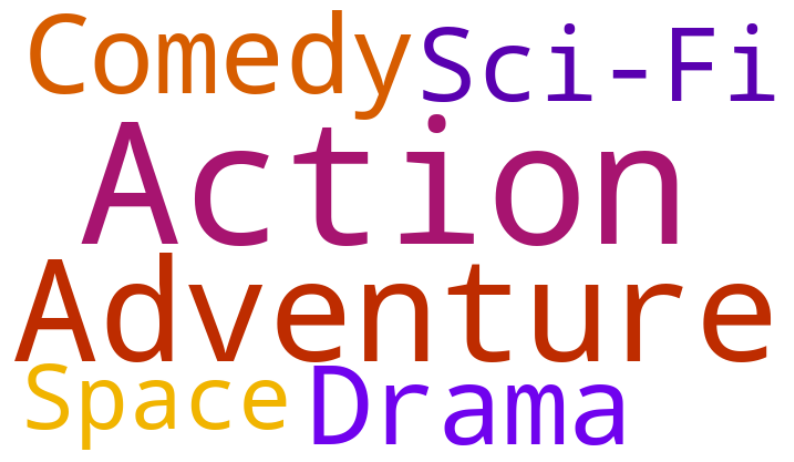

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [107]:
get_genre_by_anime(getAnimeFrame(1, df), plot=True)

In [108]:
def get_user_preferences(user_id, rating_df, df, plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    # Get the 75th percentile rating (top rated animes)
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)

    # Filter the animes watched by the user to only include those with a rating greater than or equal to the 75th percentile
    animes_watched_by_user = animes_watched_by_user[
        animes_watched_by_user.rating >= user_rating_percentile
    ]

    # Get the top rated animes watched by the user
    top_animes_user = animes_watched_by_user.sort_values(
        by="rating", ascending=False
    ).anime_id.values

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if plot:
        get_genre_by_anime(anime_df_rows, plot)

    return anime_df_rows

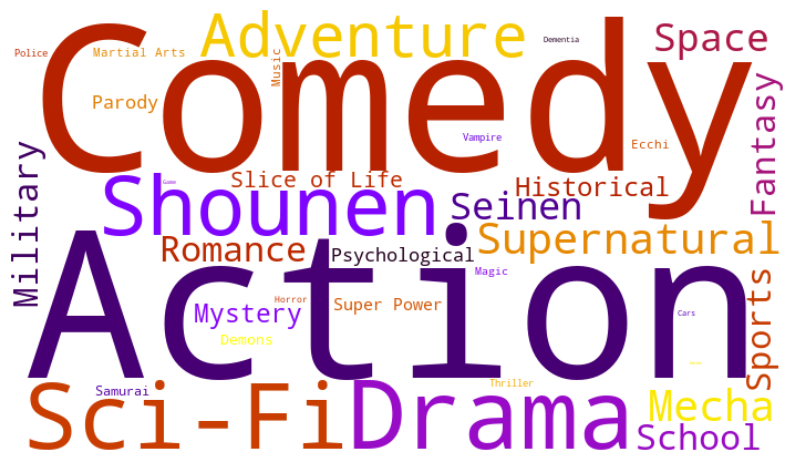

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [109]:
get_user_preferences(11880, rating_df, df, plot=True)

In [ ]:
def get_user_recommendations(
    similar_users, user_pref, df, synopsis_df, rating_df, n=10
):
    """
    Get user recommendations based on similar users and their preferences.

    Args:
        similar_users: DataFrame of similar users
        user_pref: DataFrame of this user's preferences
        df: DataFrame of anime information
        synopsis_df: DataFrame of anime synopsis
        rating_df: DataFrame of ratings
        n: Number of recommendations to return
    """

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        # Get the preferences of the similar users
        pref_list = get_user_preferences(int(user_id), rating_df, df)

        # Remove the animes that this user has already watched
        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        # Get the top n anime
        sorted_list = pd.DataFrame(
            pd.Series(anime_list.values.ravel()).value_counts()
        ).head(n)

        for i, anime_name in enumerate(sorted_list.index):
            # Get the number of times the anime was recommended by the similar users
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name, str):
                frame = getAnimeFrame(anime_name, df)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id), synopsis_df)

                recommended_animes.append(
                    {
                        "n": n_user_pref,
                        "anime_name": anime_name,
                        "Genres": genre,
                        "Synopsis": synopsis,
                    }
                )

    return pd.DataFrame(recommended_animes).head(n)

In [111]:
similar_users = find_similar_users(
    int(11880), user_weights, user2user_encoded, user2user_decoded
)

In [112]:
user_pref = get_user_preferences(11880, rating_df, df, plot=False)

In [114]:
get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df)

,n,anime_name,Genres,Synopsis
0,9,Code Geass:Lelouch of the Rebellion,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all."
1,9,Code Geass:Lelouch of the Rebellion R2,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."
2,9,Elfen Lied,"Action, Horror, Psychological, Supernatural, Drama, Romance, Seinen","ucy is a special breed of human referred to as ""Diclonius,"" born with a short pair of horns and invisible telekinetic hands that lands her as a victim of inhumane scientific experimentation by the government. However, once circumstances present her an opportunity to escape, Lucy, corrupted by the confinement and torture, unleashes a torrent of bloodshed as she escapes her captors. During her breakout, she receives a crippling head injury that leaves her with a split personality: someone with the mentality of a harmless child possessing limited speech capacity. In this state of instability, she stumbles upon two college students, Kouta and his cousin Yuka, who unknowingly take an injured fugitive into their care, unaware of her murderous tendencies. This act of kindness will change their lives, as they soon find themselves dragged into the shadowy world of government secrecy and conspiracy."
3,8,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen","shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school student and prodigy Light Yagami stumbles upon the Death Note and—since he deplores the state of the world—tests the deadly notebook by writing a criminal's name in it. When the criminal dies immediately following his experiment with the Death Note, Light is greatly surprised and quickly recognizes how devastating the power that has fallen into his hands could be. With this divine capability, Light decides to extinguish all criminals in order to build a new world where crime does not exist and people worship him as a god. Police, however, quickly discover that a serial killer is targeting criminals and, consequently, try to apprehend the culprit. To do this, the Japanese investigators count on the assistance of the best detective in the

# Hybrid recommendation


In [ ]:
def hybrid_recommendation(user_id, user_weight=0.5, content_weight=0.5):
    """
    Hybrid recommendation system that combines user-based and content-based recommendations.
    Finds user-based recommendations and then uses content-based recommendations to refine the results.

    Args:
        user_id: User ID to generate recommendations for
        user_weight: Weight for user-based recommendations
        content_weight: Weight for content-based recommendations
    """

    # User recommndation
    similar_users = find_similar_users(
        user_id, user_weights, user2user_encoded, user2user_decoded
    )

    user_pref = get_user_preferences(user_id, rating_df, df)
    user_recommended_animes = get_user_recommendations(
        similar_users, user_pref, df, synopsis_df, rating_df
    )

    # Get the list of names of recommended animes
    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    # Content recommendation
    content_recommended_anime_list = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(
            anime,
            anime_weights,
            anime2anime_encoded,
            anime2anime_decoded,
            df,
            synopsis_df,
        )

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_anime_list.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")

    print(content_recommended_anime_list)

    combined_scores = {}

    # Collect all anime recommendations from both user-based and content-based recommendations assigning weights to each
    # Changing the weights will change the importance of each recommendation type (as they get sorted by score)
    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime, 0) + user_weight

    for anime in content_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime, 0) + content_weight

    print(combined_scores)

    # print(combined_scores.items()[0][1]) -> score
    sorted_animes = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

    return [anime for anime, score in sorted_animes[:10]]

In [121]:
hybrid_recommendation(11880)

['Code Geass:Lelouch of the Rebellion', 'Code Geass:Lelouch of the Rebellion R2', 'Elfen Lied', 'Death Note', 'Attack on Titan', 'Sword Art Online', 'Steins;Gate', 'Blue Exorcist', 'Your Name.', "Howl's Moving Castle"]
['Propagate', 'Doraemon', 'Toradora! Recap', "Penguin's Memory: Shiawase Monogatari", 'Pozzie', 'Metronome', 'Kappapa', 'Bakutsuri Bar Hunter', 'Senbon Matsubara', 'Children', 'Green Makibao', 'Bust to Bust: Chichi wa Chichi ni', 'Ankoku Shinwa', 'Arslan Senki (TV) Gaiden', 'Kai: Geoul Hosu-ui Jeonseol', 'Hiiro no Kakera:The Tamayori Princess Saga Season 2', 'Kitakubu Katsudou Kiroku: Miniature Theater', 'Dark', 'The Man From; The Arrival of the Monarch', 'Tetsuwan Atom to Sagurou! Dosei wo Mawaru Shinpi no Hoshi Titan', 'Ok? Alright!', 'YAT Anshin! Uchuu Ryokou 2', 'Shigeru', 'Umeboshi Jinsei', 'Baolie Feiche II: Xing Neng Juexing', 'Crystal Clear', 'Fushigi na Taiko', 'Dream Dimension Hunter Fandora', 'Hitoribotchi', 'Free! Movie 2: Timeless Medley - Yakusoku: Characte

['Vampire in the Garden',
 'Code Geass:Lelouch of the Rebellion',
 'Code Geass:Lelouch of the Rebellion R2',
 'Elfen Lied',
 'Death Note',
 'Attack on Titan',
 'Sword Art Online',
 'Steins;Gate',
 'Blue Exorcist',
 'Your Name.']